## Explorate Data
* load single picture to checkout whether making data and loading data is right
* load the anchor to check
* load the rpn_target to check

### load_image

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from configs.config import Config
from data.io.read_tfrecord import train_input_fn, eval_predict_input_fn
from libs.box_utils.show_box_in_tensor import *
from libs.visualize import display_images, display_instances
from libs.label_dict import LABEl_NAME_MAP
from libs.box_utils.make_anchor import generate_pyramid_anchors

/root/userfolder/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
net_config = Config()
dataset = train_input_fn(net_config.DATA_DIR)
dataset_iterator = dataset.make_one_shot_iterator()
features_iter, labels_iter = dataset_iterator.get_next()
print("the tensor in features: \n {}\n the tensor in labels: \n {}"
      .format(str(features_iter), str(labels_iter)))

the tensor in features: 
 {'image_name': <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=string>, 'image': <tf.Tensor 'IteratorGetNext:0' shape=(?, ?, ?, ?) dtype=float32>, 'image_window': <tf.Tensor 'IteratorGetNext:2' shape=(?, 4) dtype=int32>}
 the tensor in labels: 
 {'gt_box_labels': <tf.Tensor 'IteratorGetNext:3' shape=(?, ?, 5) dtype=int32>, 'minibatch_indices': <tf.Tensor 'IteratorGetNext:5' shape=(?, ?) dtype=int64>, 'minibatch_encode_gtboxes': <tf.Tensor 'IteratorGetNext:4' shape=(?, ?, 4) dtype=float32>, 'minibatch_objects_one_hot': <tf.Tensor 'IteratorGetNext:6' shape=(?, ?, 2) dtype=float32>}


In [3]:
sess = tf.InteractiveSession()

### count the classes

In [4]:
total_num = np.zeros(11)
while True:
    try:
        labels = sess.run(labels_iter)
        for i in range(1, 12):
            total_num[i-1] += np.sum(labels["gt_box_labels"][:,:,4]==i)
    except:
        print(total_num)
        break

[ 1757.  3857.  1398. 26027.  1964.  4900.  4938.   324.   123.   262.
   130.]


### load example image

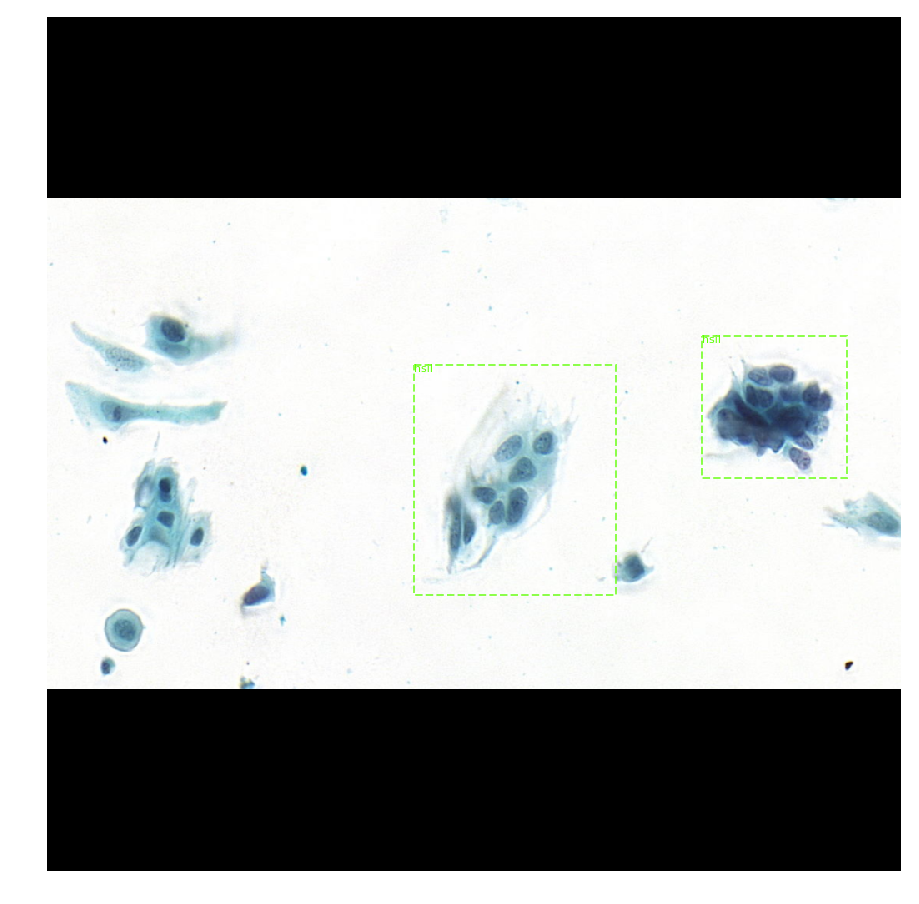

In [37]:
image_, labels = sess.run([features_iter["image"], labels_iter])
image = np.squeeze(image_)
gt_box_labels = np.squeeze(labels["gt_box_labels"])
display_instances(image, gt_box_labels[:,:4], gt_box_labels[:,4],
                  LABEl_NAME_MAP, random_color=False, num_classes=11)

###  Load rpn target anchor 

In [ ]:
fpn_anchors = generate_pyramid_anchors(net_config)
fpn_anchors = sess.run(fpn_anchors)

In [ ]:
mini_gt_box = np.squeeze(labels["minibatch_encode_gtboxes"])
invaild_mask = np.sum(np.abs(mini_gt_box), axis=1)
# 一定要先abs,然后再求,所以需要检查一下，相关所有的代码
invaild_mask = np.greater(invaild_mask, 0)
mini_indices = np.squeeze(labels["minibatch_indices"])
mini_indices = mini_indices[invaild_mask]
mini_label = np.squeeze(labels["minibatch_labels_one_hot"])
mini_label = mini_label[invaild_mask]
mini_anchors = fpn_anchors[mini_indices]
mini_anchors = np.round(mini_anchors)
mini_anchors = mini_anchors.astype(np.int32)
object_category_name = ["b","objects"]
mini_labels_index = np.argmax(mini_label, axis=1)
display_instances(image, mini_anchors, mini_labels_index,
                  object_category_name, random_color=False, num_classes=2)